In [1]:
import os
import sys
import pandas
from skimage.io import imread
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import pathlib
import tarfile

import boto3
from botocore.handlers import disable_signing

from scipy.io import loadmat
from scipy.misc import imread

import numpy as np
from skimage.transform import resize

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
 
K.set_image_dim_ordering('tf')
 
def get_unet(img_rows, img_cols, channels):
    inputs = Input((img_rows, img_cols, channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
 
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
 
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
 
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
 
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
 
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
    model = Model(inputs=[inputs], outputs=[conv10])
 
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')
    return model
unet = get_unet(256, 256, 3)
unet.load_weights('test_unet_model_10.h5')

Using TensorFlow backend.


In [3]:
def predict_custom_image(image=None, model=None):
    if isinstance(image, str):
        im = imread(image)
    else:
        im = image
    print(im.shape)
    im = (im-np.min(im))/(np.max(im)-np.min(im))  # standardization
    if len(im.shape) == 2:
        im = to_rgb1(im)

    target_size = model.input.__dict__['_keras_shape'][1:-1]

    im_resize = resize(im, target_size)
    im = np.expand_dims(im_resize, 0)
    
    preds = model.predict(im)
    pred = preds[:, :, :, 0][0]
    return pred

33.0487,12.04232,33.083259999999996,12.076880000000001
(256, 256, 3)


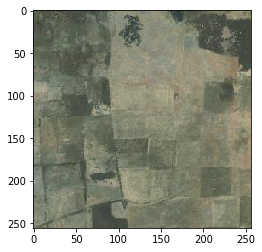

In [4]:

loc_str = '12.04232, 33.0487'
catalog_id = '254532325bfebe4b4a7cce56f0049666'
saveid = loc_str.replace(" ", "") + "," + catalog_id  
output_file = 'DGcityimages/' + saveid + '.jpg'

lon_min = float(loc_str.split(',')[1])
lat_min = float(loc_str.split(',')[0])
dims = 256
scale_factor = 50

# 50 cm
# lat_pixel_size = 4.5001883e-006
# lon_pixel_size = 4.4999137e-006

# 30 cm
lat_pixel_size = 2.7e-6
lon_pixel_size = 2.7e-6
bbox_str = str(lon_min) + ',' + str(lat_min) + ',' + str(lon_min+dims*scale_factor*lon_pixel_size*1.0) + ',' + str(lat_min+dims*scale_factor*lat_pixel_size*1.0)

print(bbox_str)

command = "curl --user Gophers:subregional.Varnished.1umbering 'https://services.digitalglobe.com/mapservice/wmsaccess?REQUEST=GetMap&SERVICE=WMS&VERSION=1.1.1&LAYERS=DigitalGlobe:Imagery&STYLES=&FORMAT=image/jpeg&BGCOLOR=0xFFFFFF&TRANSPARENT=TRUE&SRS=EPSG:4326&BBOX=" + bbox_str + "&WIDTH=" + str(dims) + "&HEIGHT=" + str(dims) + "&connectid=df282532-3390-42a8-b682-dab0abaa7b3a&featureProfile=Default_Profile&Coverage_CQL_Filter=featureId=%27" + catalog_id + "%27' -o " + output_file
os.system(command)
temp = imread(output_file)
print(temp.shape)
plt.imshow(temp)

(256, 256, 3)
(256, 256, 3)


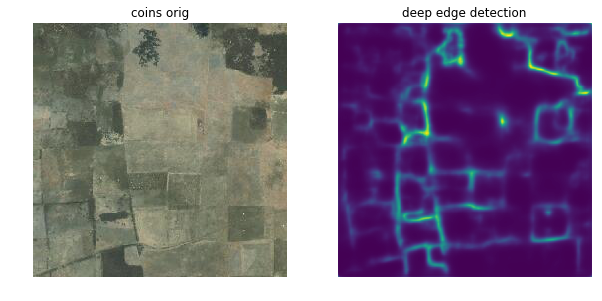

In [6]:
plt.figure(figsize=(10,10))
p = predict_custom_image(image=output_file, model=unet)

coins = imread(output_file)
print(coins.shape)
plt.subplot(121)
plt.axis('off')
plt.imshow(resize(coins, (256,256)), cmap='gray')
plt.title('coins orig')
plt.subplot(122)
plt.axis('off')
plt.title('deep edge detection')
plt.imshow(p)
plt.imsave(output_file[0:output_file.find('/')+1] + 'pred_' + output_file[output_file.find('/')+1:], p)